Caricamento del dataset da google drive:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/DataSet/DatasetTiles

Mounted at /content/gdrive/
/content/gdrive/My Drive/DataSet/DatasetTiles


LIbrerie principali da importare nel progetto:

In [17]:
import os
import time
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torch import autograd, optim
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import cv2 as cv
import glob
import datetime

**Costruzione della rete neurale U-Net**
---



Funzioni di utilità della rete:

In [3]:
def get_convolutional_layers(in_channel: int,
                             out_channel: int,
                             kernel_size: tuple = (3, 3),
                             strides: tuple = (1, 1),
                             padding: tuple = (1, 1)):
    r"""
    Convolutional layer.
    :param in_channel: number of input filters.
    :param out_channel: number of output filters.
    :param kernel_size: kernel size.
    :param strides: stride size.
    :param padding: padding size.
    """

    return nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=strides,
                     padding=padding)


def get_relu():
    r"""
    Relu activation function.
    """
    return nn.ReLU(inplace=True)


def get_sigmoid():
    r"""
    Sigmoid activation function.
    """
    return nn.Sigmoid()


def get_max_pooling(kernel_size: tuple = (2, 2),
                    strides: tuple = (2, 2)):
    r"""
    Max pooling layer.
    :param kernel_size: kernel size.
    :param strides: stride size.
    """
    return nn.MaxPool2d(kernel_size=kernel_size, stride=strides)


def get_up_sample(scale_factor: int = 2):
    r"""
    Up sample layer.
    :param scale_factor: scale factor.
    """
    return nn.Upsample(scale_factor=scale_factor)

Blocchi della rete: blocco di down-sampling, bottleneck, blocco di up-sampling e di output:

In [4]:
class Down(nn.Module):
    r"""
    Downsampling block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int):
        r"""
        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        """
        super().__init__()

        self.conv_1 = get_convolutional_layers(in_channel, out_channel)
        self.conv_2 = get_convolutional_layers(out_channel, out_channel)
        self.activation = get_relu()
        self.max_pooling = get_max_pooling()

    def forward(self, x):
        r"""
        Forward down block.
        """
        out_conv = self.conv_1(x)
        out_relu = self.activation(out_conv)

        out_conv = self.conv_2(out_relu)
        out_relu = self.activation(out_conv)

        out_pooling = self.max_pooling(out_relu)
        return out_relu, out_pooling


class Bottleneck(nn.Module):
    r"""
    Bottleneck block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int):
        r"""

        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        """
        super().__init__()

        self.conv_1 = get_convolutional_layers(in_channel, out_channel)
        self.conv_2 = get_convolutional_layers(out_channel, out_channel)
        self.activation = get_relu()

    def forward(self, x):
        r"""
        Forward bottleneck block.
        """
        out_conv = self.conv_1(x)
        out_relu = self.activation(out_conv)

        out_conv = self.conv_2(out_relu)
        out_relu = self.activation(out_conv)

        return out_relu


class Up(nn.Module):
    r"""
    Upsampling block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int):
        r"""
        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        """
        super().__init__()

        self.up_sample = get_up_sample()
        self.concat = Concat()
        self.activation = get_relu()
        self.conv_1 = get_convolutional_layers(in_channel=in_channel, out_channel=out_channel)
        self.conv_2 = get_convolutional_layers(out_channel, out_channel)

    def forward(self, x, skip):
        r"""
        Forward upblock.
        :param x: input layer.
        :param skip: skip connection layer to concatenate.
        """
        out_up = self.up_sample(x)
        out_concat = self.concat(out_up, skip)
        out_conv = self.conv_1(out_concat)
        out_relu = self.activation(out_conv)
        out_conv = self.conv_2(out_relu)
        out_relu = self.activation(out_conv)

        return out_relu


class Concat(nn.Module):
    r"""
    Concatenate class.
    Concatenate two levels of the network.
    """

    def __init__(self):
        super().__init__()

    def forward(self, layer_1, layer_2):
        out_concat = torch.cat((layer_1, layer_2), dim=1)
        return out_concat


class Out(nn.Module):
    r"""
    Output block.
    """

    def __init__(self,
                 in_channel: int,
                 out_channel: int,
                 kernel_size: tuple):
        r"""
        :param in_channel: number of input filters.
        :param out_channel: number of output filters.
        :param kernel_size: kernel size.
        """
        super().__init__()

        self.conv = get_convolutional_layers(in_channel=in_channel, out_channel=out_channel, kernel_size=kernel_size,
                                             padding=(0, 0))
        self.sigmoid = get_sigmoid()

    def forward(self, x: torch.Tensor):
        r"""
        Forward output block.
        """
        out_conv = self.conv(x)
        out_sigmoid = self.sigmoid(out_conv)

        return out_sigmoid

Corpo della rete:

In [5]:
class Unet(nn.Module):
    r"""
    U-net class.
    """

    def __init__(self,
                 n_classes_out: int,
                 block_filter_count = [3, 64, 128, 256, 512, 1024]):
        r"""
        Builder of the class.
        :param n_classes_out: number of classes of the problem.
        :param block_filter_count: number of filters for each convolutional layer.
        """
        super(Unet, self).__init__()

        self.blocks_down = []
        self.blocks_up = []

        # Down sampling path
        print("** Block downs **")
        for i in range(0, 4):
            block = Down(in_channel=block_filter_count[i], out_channel=block_filter_count[i + 1])
            print(f"Block down {i + 1}-layer: in: {block_filter_count[i]}, out: {block_filter_count[i + 1]}")
            self.blocks_down.append(block)

        # Bottleneck
        print("\n** Bottleneck **")
        self.bottleneck = Bottleneck(in_channel=block_filter_count[4], out_channel=block_filter_count[5])
        print(f"Bottleneck layer: in: {block_filter_count[4]}, out: {block_filter_count[5]}")

        # Up sampling path
        print("\n** Block ups **")
        for i in range(0, 4):
            block = Up(in_channel=block_filter_count[5 - i] + block_filter_count[5 - (i + 1)],
                             out_channel=block_filter_count[5 - (i + 1)])
            print(
                f"Block ups {i + 1}-layer: in: {block_filter_count[5 - i] + block_filter_count[5 - (i + 1)]}, out: {block_filter_count[5 - (i + 1)]}")
            self.blocks_up.append(block)

        # Output layer
        print("\n** Out net **")

        self.out = Out(in_channel=block_filter_count[1], out_channel=n_classes_out, kernel_size=(1, 1))
        print(f"Out layer: in: {block_filter_count[1]}, out: {n_classes_out}\n")

        self.blocks_down = nn.ModuleList(self.blocks_down)
        self.bottleneck = nn.ModuleList([self.bottleneck])
        self.blocks_up = nn.ModuleList(self.blocks_up)

    def forward(self, x: torch.Tensor):
        r"""
        Forward of the network.
        :param x: input net.
        :return: output net.
        """

        encoder = []

        # Down sampling path
        for block in self.blocks_down:
            out_conv, out_pool = block(x)

            encoder.append(out_conv)
            x = out_pool

        out_down_blocks = x

        # Bottleneck
        bn = self.bottleneck[0](out_down_blocks)
        x = bn

        # Up sampling path
        for index, block in enumerate(self.blocks_up):
            x = block(x, encoder[len(encoder) - (index + 1)])

        # Output layer
        out_net = self.out(x)

        return out_net


Metriche per valutare i risultati della rete:

In [6]:
def numeric_score(prediction, ground_truth):
    r"""
    Calculation prediction.
    """

    prediction[prediction > 0.9] = 1
    prediction[prediction <= 0.9] = 0

    false_positive = np.float(np.sum((prediction == 1) & (ground_truth == 0)))
    false_negative = np.float(np.sum((prediction == 0) & (ground_truth == 1)))
    true_positive = np.float(np.sum((prediction == 1) & (ground_truth == 1)))
    true_negative = np.float(np.sum((prediction == 0) & (ground_truth == 0)))

    return false_positive, false_negative, true_positive, true_negative


def accuracy(prediction, ground_truth):
    r"""
    Calculation of accuracy.
    :return: system accuracy.
    """

    false_positive, false_negative, true_positive, true_negative = numeric_score(prediction, ground_truth)
    total_prediction = false_positive + false_negative + true_positive + true_negative
    acc = np.divide(true_positive + true_negative, total_prediction) * 100

    return acc

Classe Early stopping:

In [7]:
class EarlyStopping:
    r"""
    Class that implements early stopping to end network training to avoid the overfitting.
    """

    def __init__(self, patience=5):
        r"""
        Constructor of class.
        :param patience: number of epochs to wait to finish the training.
        """
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):

        if self.best_loss is None or val_loss > self.best_loss:
            # Update the best loss field
            self.best_loss = val_loss

        elif self.best_loss - val_loss < 0:

            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")

            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

# **Dataset**

Classe per caricamento del dataset nella rete con successiva pre-elaborazione delle immagini:

In [8]:
WIDTH = 256
HEIGHT = 256


class DatasetTiles(Dataset):
    r"""
    Class to load the dataset of a specific defect.
    """

    def __init__(self, parent_dir, image_dir):
        r"""
        Load the dataset.
        :param parent_dir: root folder.
        :param image_dir: directory of the defect.

        Image format:
            - .jpg: image
            - .png: binay mask
        """
        self.img_list_path = glob.glob(parent_dir + '/' + image_dir + '/Imgs/*.jpg')
        self.img_mask_list_path = glob.glob(parent_dir + '/' + image_dir + '/Imgs/*.png')
        print(f"{image_dir} loaded!")

    def __getitem__(self, index):
        r"""
        Get the image and its mask
        :param index: index of the specific image
        """

        x = preprocessing(self.img_list_path[index], False)
        # Resize input format [height, width, n_channels]
        x = np.rollaxis(x, 2, 0)

        y = preprocessing(self.img_mask_list_path[index], True)
        # Add 1 channel to input. Input format [height, width, n_channels]
        y = np.expand_dims(y, axis=0)

        return x, y

    def __len__(self):
        return len(self.img_list_path)


def preprocessing(img, convert_to_gray):
    r"""
    Performs a preprocessing on the image.
    :param img: img to be processed
    :param convert_to_gray: true if the conversion is grayscale, false otherwise.
    """

    img = cv.imread(img)
    img = cv.resize(img, (WIDTH, HEIGHT))

    if convert_to_gray:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    else:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    img = img / 255
    img = img.astype(np.float32)

    return img


def train_test_split(dataset):
    r"""
    Slip dataset in training, validation and test set:
        - 70% training set;
        - 20% validation set:
        - 10% test set.

    :param dataset: dataset to split
    :return : training, validation and test set.
    """
    length_dataset = len(dataset)

    length_train = np.int_(length_dataset * 0.7)
    length_validate = np.int_(length_dataset * 0.2)

    training_dataset = Subset(dataset, range(0, length_train))
    validation_dataset = Subset(dataset, range(length_train, length_train + length_validate))
    test_dataset = Subset(dataset, range(length_train + length_validate, len(dataset)))

    return training_dataset, validation_dataset, test_dataset


# **Grafici**

Funzioni di utilità per mostrare grafici:

In [20]:
def plot_history(loss_train, loss_valid, accuracy_valid, num_epochs):
    r"""
    Shows the results obtained.
    :param loss_train: loss obtained from the training data
    :param loss_valid: loss obtained from the validation data
    :param accuracy_valid: accuracy obtained
    :param num_epochs: number of epochs
    """

    plot_epoch = np.arange(0, num_epochs)

    plt.figure(1)
    plt.plot(plot_epoch[0:num_epochs], loss_train[0:num_epochs], linestyle='-', marker='',
             linewidth=3, alpha=0.9)
    plt.plot(plot_epoch[0:num_epochs], loss_valid[0:num_epochs], linestyle='-', marker='',
             linewidth=3, alpha=0.9)
    plt.xlabel('Epoch number')
    plt.ylabel('Loss')
    plt.gca().legend(('Training loss', 'Validation loss'), loc='upper right')
    plt.title('Loss history')
    plt.show()

    plt.figure(2)
    plt.plot(plot_epoch[0:num_epochs], accuracy_valid[0:num_epochs], linestyle='-', marker='',
             linewidth=3, alpha=0.9, label="Accuracy")
    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy')
    plt.gca().legend(loc='upper right')
    plt.title('Accuracy history')
    plt.show()


def sample_dataset(data_loader, batch_size):
    r"""
    Shows an example of the training dataset
    :param data_loader: dataset
    :param batch_size: number of batch size
    """

    counter = 0
    random_seed_1 = random.randint(0, len(data_loader) - 1)
    random_seed_2 = random.randint(0, len(data_loader) - 1)
    for sample_image, sample_label in data_loader:

        if counter == random_seed_1 or counter == random_seed_2:
            random_batch = random.randint(0, batch_size - 1)
            plot_samples(random_batch, sample_image, sample_label)
        counter += 1


def plot_samples(index, img, label):
    r"""
    Plot examples of the dataset.
    :param index: index of the array
    :param img: img to plot
    :param label: label to plot
    """

    sample_image = img[index]
    sample_label = label[index]

    img = np.squeeze(sample_image)
    img = img[0, :, :]
    plt.title('Image')
    plt.imshow(img, cmap="gray")
    plt.show()

    label = np.squeeze(sample_label)
    plt.title('Label')
    plt.imshow(label, cmap="gray")
    plt.show()


def plot_test_results(images, masks, predicted, value):
    r"""
    PLot test results.
    :param images: collection of images of the dataset.
    :param masks: collection of masks of the dataset.
    :param predicted: images predicted by the network.
    :param value: initial value of loop.
    """

    if value >= len(images):
        raise Exception("The value must be less than the number of images")

    counter = 1
    for i in range(value, len(images)):
        img = images[i]
        img = np.squeeze(img)
        img = img[0, 0, :]

        mask = masks[i]
        mask = np.squeeze(mask)
        mask = mask[0, :, :]

        predict = predicted[i]
        predict = np.squeeze(predict)
        predict = predict[0, :, :]

        # Image
        plt.title(f'Image: {counter}')
        plt.imshow(img, cmap="gray")
        plt.show()

        # Label
        plt.title(f'Mask: {counter}')
        plt.imshow(mask, cmap="gray")
        plt.show()

        # Predict
        plt.title(f'Predict: {counter}')
        plt.imshow(predict, cmap="gray")
        plt.show()

        counter += 1

# **Training**

Training della rete:

In [15]:
SHOW_EVERY = 1
PARENT_DIR = "ModelSaved"


def training_loop(model, num_epochs, optimizer, lr_scheduler, loss_fn, training_loader, validation_loader):
    r"""
    Network training
    :param model: neural network model
    :param num_epochs: number of epochs
    :param optimizer: optimize used
    :param lr_scheduler: scheduler used
    :param loss_fn: loss function used
    :param training_loader: training data
    :param validation_loader: validation data
    """

    print("\n** Training **\n")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    folder = create_directory()

    # Initialized params before training
    # Loss
    training_loss_arr = []
    validation_loss_arr = []

    # Accuracy
    training_accuracy_arr = []
    validation_accuracy_arr = []

    # Parameters to plot loss and accuracy
    plot_train_loss = np.zeros(num_epochs)
    plot_validate_loss = np.zeros(num_epochs)
    plot_validate_accuracy = np.zeros(num_epochs)

    # Early stopping
    early_stopping = EarlyStopping()

    for epoch in range(0, num_epochs):
        print(f"--> Epoch: {epoch + 1}/{num_epochs}")

        # Training steps
        training_loss_batch = 0.0
        training_accuracy_batch = 0.0
        num_steps = 0

        for _, batch in enumerate(training_loader):
            torch.cuda.empty_cache()

            # Training model
            model.train()

            # Split the train data from the labels
            X = batch[0].to(device)
            y = batch[1].to(device)
            y[y > 0] = 1

            # Forward pass
            y_predicted = model(X)
            loss = loss_fn(y_predicted, y)

            optimizer.zero_grad()

            # Backward pass
            loss.backward()
            optimizer.step()

            training_loss_batch += loss.item()
            training_accuracy_batch += accuracy(y_predicted.cpu().detach().numpy(),
                                                y.cpu().detach().numpy())

            num_steps += 1

        train_loss_for_this_epoch = np.divide(training_loss_batch, num_steps)
        training_loss_arr.append(train_loss_for_this_epoch)
        training_accuracy_arr.append(np.divide(training_accuracy_batch, num_steps))

        # Set loss (training) for each epoch
        plot_train_loss[epoch] = train_loss_for_this_epoch

        # Validation
        with torch.no_grad():

            num_steps = 0
            validation_loss_batch = 0.0
            validation_accuracy_batch = 0.0

            model.eval()

            # Validation steps
            for index, batch in enumerate(validation_loader):
                torch.cuda.empty_cache()

                X = batch[0].to(device)
                y = batch[1].to(device)
                y[y > 0] = 1

                y_predicted = model(X)
                loss = loss_fn(y_predicted, y)
                validation_loss_batch += loss.item()

                validation_accuracy_batch += accuracy(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())

                num_steps += 1

            valid_loss_for_this_epoch = np.divide(validation_loss_batch, num_steps)
            valid_accuracy_for_this_epoch = np.divide(validation_accuracy_batch, num_steps)

            validation_loss_arr.append(valid_loss_for_this_epoch)
            validation_accuracy_arr.append(valid_accuracy_for_this_epoch)

            # Set loss and accuracy (validation) for each epoch
            plot_validate_loss[epoch] = train_loss_for_this_epoch
            plot_validate_accuracy[epoch] = valid_accuracy_for_this_epoch

        if epoch % SHOW_EVERY == 0 or epoch == num_epochs - 1:
            print(f"** Training\n\t\tLoss: {np.round(np.mean(training_loss_arr), 4)}\n\t\t"
                  f"Accuracy: {np.round(np.mean(training_accuracy_arr), 4)}\n**\n\n")

            print(f"** Validation\n\t\tLoss: {np.round(np.mean(validation_loss_arr), 4)}\n\t\t"
                  f"Accuracy: {np.round(np.mean(validation_accuracy_arr), 4)}\n**\n\n")

        if epoch % 10 == 0:
            # Save model each 10 epochs
            save_model(model, epoch, optimizer, training_loss_arr, validation_loss_arr, training_accuracy_arr,
                       validation_accuracy_arr, folder, f"model_epoch_{epoch + 1}.pth")

        early_stopping(validation_loss_arr)
        if early_stopping.early_stop or epoch == num_epochs - 1:
            save_model(model, epoch, optimizer, training_loss_arr, validation_loss_arr, training_accuracy_arr,
                       validation_accuracy_arr, folder, "best_model.pth")

            # Stop training
            break

        lr_scheduler.step()

    return plot_train_loss, plot_validate_loss, plot_validate_accuracy


def test(test_loader, model, loss_fn):
    r"""
    Show test results of the neural network.
    :param test_loader: test data.
    :param model: net model.
    :param loss_fn: loss function used.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_loss_arr = []
    test_accuracy_arr = []

    # Parameters to plot the results
    plot_img = []
    plot_mask = []
    plot_predicted = []

    # Test
    with torch.no_grad():
        model.eval()

        # Test steps
        test_loss_batch = 0.0
        test_accuracy_batch = 0.0
        num_steps = 0

        for index, batch in enumerate(test_loader):
            torch.cuda.empty_cache()

            X = batch[0].to(device)
            y = batch[1].to(device)
            y[y > 0] = 1

            y_predicted = model(X)

            plot_img.append(X.cpu().detach().numpy())
            plot_mask.append(y.cpu().detach().numpy())
            plot_predicted.append(y_predicted.cpu().detach().numpy())

            loss = loss_fn(y_predicted, y)
            test_loss_batch += loss.item()

            test_accuracy_batch += accuracy(y_predicted.cpu().detach().numpy(), y.cpu().detach().numpy())

            num_steps += 1

        test_loss_arr.append(np.divide(test_loss_batch, num_steps))
        test_accuracy_arr.append(np.divide(test_accuracy_batch, num_steps))

        print(f"** Test\n\t\tLoss: {np.round(np.mean(test_loss_arr), 4)}\n\t\t"
              f"Accuracy: {np.round(np.mean(test_accuracy_arr), 4)}\n**\n\n")

    return plot_img, plot_mask, plot_predicted


def save_model(model, epoch, optimizer, training_loss, validation_loss, training_acc, validation_acc, new_dir,
               name_file):
    r"""
    Save the model.
    :param model: model to saved.
    :param epoch: current epoch.
    :param optimizer: net optimizer.
    :param training_loss: training loss.
    :param training_acc: training accuracy.
    :param validation_loss: validation loss.
    :param validation_acc: validation accuracy.
    :param new_dir: new directory created.
    :param name_file: name file to be saved. (Extension file .pth)
    """

    checkpoint = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'Training Loss': np.round(np.mean(training_loss), 4),
        'Validation Loss': np.round(np.mean(validation_loss), 4),
        'Training Accuracy': np.round(np.mean(training_acc), 4),
        'Validation Accuracy': np.round(np.mean(validation_acc), 4)
    }

    torch.save(checkpoint, PARENT_DIR + "/" + new_dir + "/" + name_file)
    print(f"[{epoch + 1}] Model saved!\n")


def create_directory():
    r"""
    Create directory for saved model.
    """

    current_date_hour = datetime.datetime.now()
    new_dir = f"{current_date_hour.year}{current_date_hour.month}{current_date_hour.day}-" \
              f"{current_date_hour.hour}{current_date_hour.minute}{current_date_hour.second}"

    path = PARENT_DIR + "/" + new_dir

    try:
      os.mkdir(PARENT_DIR)
    except:
      pass
      
    os.mkdir(path)

    print("Directory created!\n")

    return new_dir


Costruzione della rete, caricamento del dataset, setting degli iperparametri, training della rete:

Loading dataset in progress ...
MT_Blowhole loaded!
MT_Break loaded!
MT_Crack loaded!
MT_Fray loaded!
MT_Free loaded!
MT_Uneven loaded!
** Dataset loaded correctly! Imgs: 1344 **

Size train: 940 - 70%
Size validation: 268 - 20%
Size test: 136 - 10%
Total imgs splitted: 1344


** Block downs **
Block down 1-layer: in: 3, out: 64
Block down 2-layer: in: 64, out: 128
Block down 3-layer: in: 128, out: 256
Block down 4-layer: in: 256, out: 512

** Bottleneck **
Bottleneck layer: in: 512, out: 1024

** Block ups **
Block ups 1-layer: in: 1536, out: 512
Block ups 2-layer: in: 768, out: 256
Block ups 3-layer: in: 384, out: 128
Block ups 4-layer: in: 192, out: 64

** Out net **
Out layer: in: 64, out: 1

Shape out net: torch.Size([1, 1, 256, 256]) 

** Training **

Directory created!

--> Epoch: 1/1
** Training
		Loss: 0.6418
		Accuracy: 98.8931
**


** Validation
		Loss: 0.6083
		Accuracy: 100.0
**


[1] Model saved!

[1] Model saved!

** Training time: 4.488 minutes **




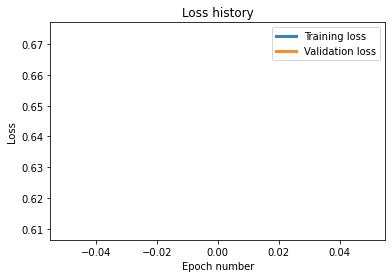

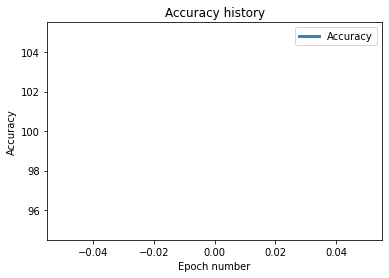

** Test
		Loss: 0.6409
		Accuracy: 81.5023
**




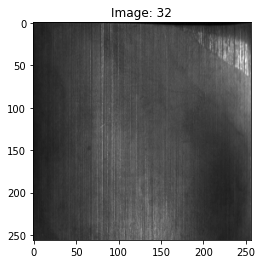

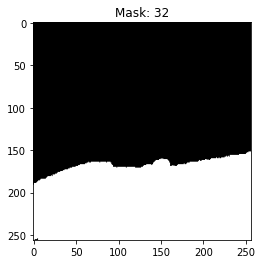

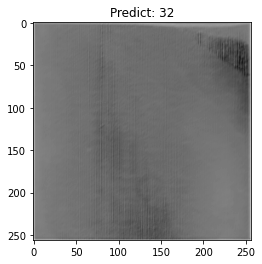

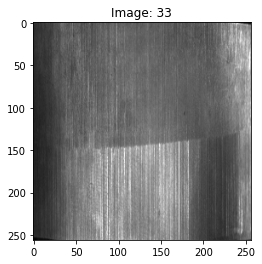

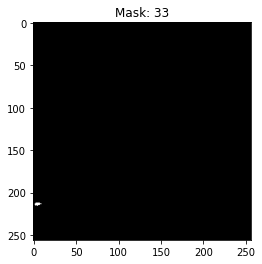

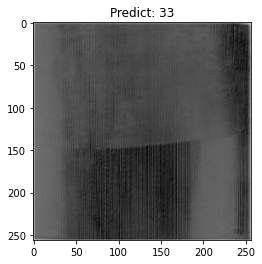

In [19]:
SHOW_SAMPLES_TRAIN = False
SHOW_SUMMARY = False

parent_dir = "/content/gdrive/MyDrive/DataSet/DatasetTiles"
BLOWHOLE = "MT_Blowhole"
BREAK = "MT_Break"
CRACK = "MT_Crack"
FRAY = "MT_Fray"
FREE = "MT_Free"
UNEVEN = "MT_Uneven"
defects = [BLOWHOLE, BREAK, CRACK, FRAY, FREE, UNEVEN]
datasets = []

n_classes = 1

# Loaded dataset
print("Loading dataset in progress ...")
for defect in defects:
    datasets.append(DatasetTiles(parent_dir, defect))

dataset = ConcatDataset(datasets)
print(f"** Dataset loaded correctly! Imgs: {len(dataset)} **\n")

training_dataset, validation_dataset, test_dataset = train_test_split(dataset)
print(f"Size train: {len(training_dataset)} - 70%")
print(f"Size validation: {len(validation_dataset)} - 20%")
print(f"Size test: {len(test_dataset)} - 10%")
print(f"Total imgs splitted: {len(training_dataset) + len(validation_dataset) + len(test_dataset)}\n\n")

batch_size = 4 #8

# Training set
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False)

# Validation set
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Show samples train dataset
if SHOW_SAMPLES_TRAIN:
    sample_dataset(data_loader=training_loader, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(n_classes_out=n_classes)
model = model.to(device)

x = torch.randn(size=(1, 3, 256, 256), dtype=torch.float32).cuda()
with torch.no_grad():
    out = model(x)

print(f'Shape out net: {out.shape} ')

if SHOW_SUMMARY:
    summary(model, (3, 256, 256))

num_epochs = 1  # 100
criterion = nn.BCELoss()  # Binary cross-entropy
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.0001)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

start_time = time.time()

# Training model
loss_train, loss_valid, accuracy_valid = training_loop(model=model,
                                                       num_epochs=num_epochs,
                                                       optimizer=optimizer,
                                                       lr_scheduler=lr_scheduler,
                                                       loss_fn=criterion,
                                                       training_loader=training_loader,
                                                       validation_loader=validation_loader)
end_time = time.time()
print(f"** Training time: {round(((end_time - start_time) / 60), 3)} minutes **\n\n")

# Show loss and accuracy
plot_history(loss_train=loss_train, loss_valid=loss_valid, accuracy_valid=accuracy_valid, num_epochs=num_epochs)

# Test
test_images, test_masks, test_predicted = test(test_loader=test_loader, model=model, loss_fn=criterion)
plot_test_results(test_images, test_masks, test_predicted, len(test_images) - 2)
